## Question 3: Regression - Combined Cycle Power Plant
- Use CCPP dataset to build a model to predict the net hourly electrical energy output (EP) of the plant based on Features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V)
- Read more information here:
http://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant

# 0.Working environment preparation & Package import

In [1]:
# !apt-get update

In [2]:
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q http://archive.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
# !tar -xvf spark-2.4.0-bin-hadoop2.7.tgz
# !pip install -q findspark
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

In [4]:
# %cd "/content/gdrive/MyDrive/LDS9_K272_ONLINE_DamThiMinhPhuong/Demo/Chapter7"

In [5]:
import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# 1. Dataset understanding

In [7]:
spark = SparkSession.builder.appName('Q3_regression').getOrCreate()

22/01/20 14:42:40 WARN Utils: Your hostname, Ellies-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.3 instead (on interface en0)
22/01/20 14:42:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/01/20 14:42:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [8]:
# Read excel file using pandas
xls = pd.ExcelFile('data/CCPP/Folds5x2_pp.xlsx')
df1 = pd.read_excel(xls, 'Sheet1')
df2 = pd.read_excel(xls, 'Sheet2')
df3 = pd.read_excel(xls, 'Sheet3')
df4 = pd.read_excel(xls, 'Sheet4')
df5 = pd.read_excel(xls, 'Sheet5')

In [9]:
# concat 5 sheets into 1
df = pd.concat([df1, df2, df3, df4, df5])
df.head(3)

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56


In [10]:
df.shape

(47840, 5)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47840 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      47840 non-null  float64
 1   V       47840 non-null  float64
 2   AP      47840 non-null  float64
 3   RH      47840 non-null  float64
 4   PE      47840 non-null  float64
dtypes: float64(5)
memory usage: 2.2 MB


In [12]:
# convert pandas dataframe to pyspark dataframe
df_schema = StructType([StructField("AT", FloatType(), True),
                        StructField("V" , FloatType(), True),
                        StructField("AP", FloatType(), True),
                        StructField("RH", FloatType(), True),
                        StructField("PE", FloatType(), True),
                       ])
data = spark.createDataFrame(df, schema=df_schema)

In [13]:
data.count()

47840

In [14]:
data.printSchema()

root
 |-- AT: float (nullable = true)
 |-- V: float (nullable = true)
 |-- AP: float (nullable = true)
 |-- RH: float (nullable = true)
 |-- PE: float (nullable = true)



In [15]:
data.show(5)

+-----+-----+-------+-----+------+
|   AT|    V|     AP|   RH|    PE|
+-----+-----+-------+-----+------+
|14.96|41.76|1024.07|73.17|463.26|
|25.18|62.96|1020.04|59.08|444.37|
| 5.11| 39.4|1012.16|92.14|488.56|
|20.86|57.32|1010.24|76.64|446.48|
|10.82| 37.5|1009.23|96.62| 473.9|
+-----+-----+-------+-----+------+
only showing top 5 rows



# 2. Data preprocessing

## --- Data cleaning

In [16]:
# Check null values
data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).toPandas()

,AT,V,AP,RH,PE
0,0,0,0,0,0


In [17]:
data.select([count(when(isnan(c), c)).alias(c) for c in data.columns]).toPandas()

,AT,V,AP,RH,PE
0,0,0,0,0,0


In [18]:
# Check duplicates
dup_rows = data.count() - data.distinct().count()
dup_rows

38313

In [19]:
# Drop duplicates
data = data.drop_duplicates()
data.count()

9527

## --- Univariate

In [20]:
data.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+
|summary|                AT|                 V|                AP|                RH|                PE|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|              9527|              9527|              9527|              9527|              9527|
|   mean|19.658225052652273|  54.2934207529865|1013.2370842767185| 73.33495117272386|454.33590958347924|
| stddev| 7.444397081939809|12.686309047114976|5.9405260914255225|14.607513245887038| 17.03908021822378|
|    min|              1.81|             25.36|            992.89|             25.56|            420.26|
|    max|             37.11|             81.56|            1033.3|            100.16|            495.76|
+-------+------------------+------------------+------------------+------------------+------------------+



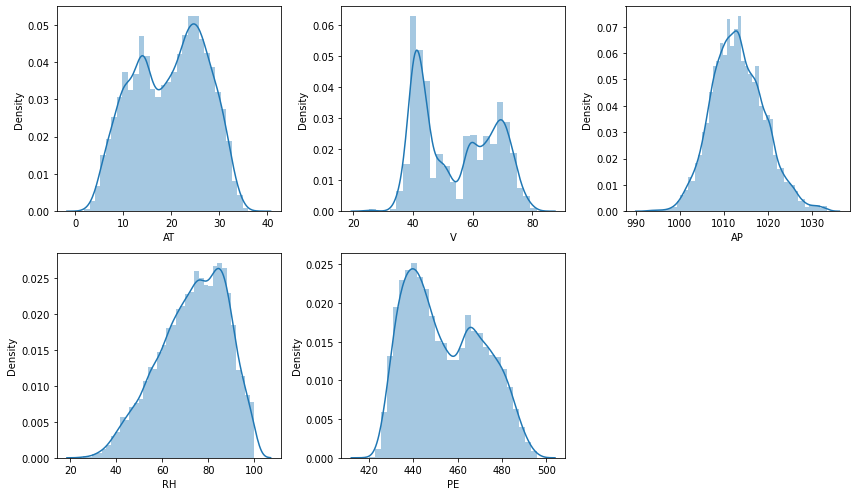

In [21]:
plt.figure(figsize=(12,7))
for i in range(1,6):
    plt.subplot(2,3,i)
    sns.distplot(data.toPandas()[data.columns[i-1]])
plt.tight_layout()
plt.show()

### Nhận xét:
- Các biến đều không có phân phối theo phân phối chuẩn

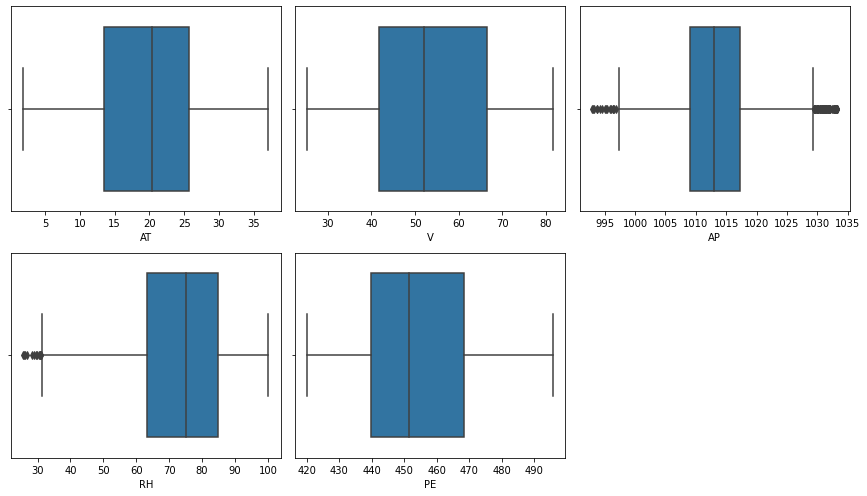

In [22]:
plt.figure(figsize=(12,7))
for i in range(1,6):
    plt.subplot(2,3,i)
    sns.boxplot(data.toPandas()[data.columns[i-1]])
plt.tight_layout()
plt.show()

### Nhận xét:
- Các biến AP, RH có outliers
- AT, V, PE không có outliers

## --- Bivariate

In [23]:
# sns.pairplot(data.toPandas())
# plt.show()

In [24]:
data.toPandas().corr()

,AT,V,AP,RH,PE
AT,1.000000,0.843689,-0.508222,-0.543947,-0.947908
V,0.843689,1.000000,-0.415718,-0.312214,-0.869900
AP,-0.508222,-0.415718,1.000000,0.101631,0.518687
RH,-0.543947,-0.312214,0.101631,1.000000,0.391175
PE,-0.947908,-0.869900,0.518687,0.391175,1.000000


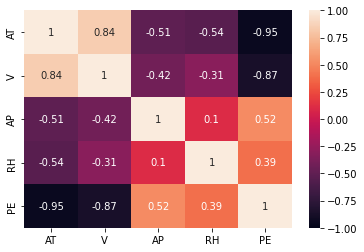

In [25]:
sns.heatmap(data.toPandas().corr(), vmin=-1, vmax=1, annot=True)
plt.show()

### Nhận xét:
- Các biến AT, V có tương quan mạnh với nhau (0.84) và tương quan mạnh với output PE

## --- Drop outliers

In [26]:
def drop_outliers(data, contVar):
    mean_val = data.agg({contVar:'mean'}).collect()[0][0]
    stddev_val = data.agg({contVar:'stddev'}).collect()[0][0]

    low_bound = mean_val - (3*stddev_val)
    high_bound = mean_val + (3*stddev_val)

    data = data.where((data[contVar]>=low_bound) & (data[contVar]<=high_bound))
    return data

In [27]:
for contVar in data.columns:
    data = drop_outliers(data, contVar)
data.count()

9470

In [28]:
# Thực hiện MinMaxScaler
def min_max_scaler(df, cols_to_scale):
    # Takes a dataframe and list of columns to minmax scale. Returns a dataframe.
    for col in cols_to_scale:
        # Define min and max values and collect them
        max_values = df.agg({col: 'max'}).collect()[0][0]
        min_values = df.agg({col: 'min'}).collect()[0][0]
        new_column_name = 'scaled_' + col
        # Create a new column based off the scaled data
        df = df.withColumn(new_column_name, 
                      (df[col] - min_values) / (max_values - min_values))
    return df

In [29]:
data = min_max_scaler(data, data.columns)
data.show(5)

+-----+-----+-------+-----+------+-------------------+-------------------+-------------------+-------------------+-------------------+
|   AT|    V|     AP|   RH|    PE|          scaled_AT|           scaled_V|          scaled_AP|          scaled_RH|          scaled_PE|
+-----+-----+-------+-----+------+-------------------+-------------------+-------------------+-------------------+-------------------+
|27.62|71.14| 1011.6| 52.8|434.72| 0.7311614846558331| 0.8145907698439612|0.45416098109386127|0.33041139294098204|0.19152306563017385|
|15.84|52.72|1026.45|62.57|464.93|0.39745042335641834|0.48683277750973836| 0.8717643726989521| 0.4685423132586315| 0.5916554027835265|
|27.04|65.06|1013.33|52.37|439.84| 0.7147308922270101| 0.7064056780074953| 0.5028123203144443|0.32433193182451897| 0.2593375704935844|
|17.78|50.66|1015.09| 91.9|456.11|0.45240794452835925| 0.4501779468130714| 0.5523064116097252|  0.883217846116209|0.47483411372102646|
|31.76|66.54|1003.02|49.64|430.18|  0.848441918405275| 

## --- Formating data

In [30]:
assembler = VectorAssembler(
                    inputCols=['scaled_AT', 'scaled_AP','scaled_RH', 'scaled_V'],
                    outputCol='features'
                            )

In [31]:
data_pre = assembler.transform(data)

In [32]:
data_pre.select('features').show(3, False) 

+-------------------------------------------------------------------------------+
|features                                                                       |
+-------------------------------------------------------------------------------+
|[0.7311614846558331,0.45416098109386127,0.33041139294098204,0.8145907698439612]|
|[0.39745042335641834,0.8717643726989521,0.4685423132586315,0.48683277750973836]|
|[0.7147308922270101,0.5028123203144443,0.32433193182451897,0.7064056780074953] |
+-------------------------------------------------------------------------------+
only showing top 3 rows



In [33]:
final_data = data_pre.select('features','PE')
final_data.show(3)

+--------------------+------+
|            features|    PE|
+--------------------+------+
|[0.73116148465583...|434.72|
|[0.39745042335641...|464.93|
|[0.71473089222701...|439.84|
+--------------------+------+
only showing top 3 rows



In [34]:
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

In [35]:
train_data.describe().show()

+-------+------------------+
|summary|                PE|
+-------+------------------+
|  count|              7644|
|   mean| 454.4092949149123|
| stddev|17.078811109537284|
|    min|            420.26|
|    max|            495.76|
+-------+------------------+



In [36]:
test_data.describe().show()

+-------+------------------+
|summary|                PE|
+-------+------------------+
|  count|              1826|
|   mean| 453.5372126434092|
| stddev|16.695019574996863|
|    min|            421.57|
|    max|            494.91|
+-------+------------------+



# 3. Build Model
- Model 1: Linear Regression
- Model 2: Decision Tree Regressor
- Model 3: Random Forest Regressor
- Model 4: GBT Regressor

## --- Linear Regression

In [37]:
lr = LinearRegression(featuresCol='features', #inputs
                      labelCol='PE', #ouput
                      predictionCol='Predict_PE'  #prediction
                     )

In [38]:
lrModel = lr.fit(train_data)

22/01/20 14:43:22 WARN Instrumentation: [df9714d0] regParam is zero, which might cause numerical instability and overfitting.
22/01/20 14:43:22 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/01/20 14:43:22 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/01/20 14:43:22 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [39]:
# Check test dataset
test_model_1 = lrModel.transform(test_data)

In [40]:
# Inspect result
test_model_1.select('Predict_PE','PE').show(5)

+------------------+------+
|        Predict_PE|    PE|
+------------------+------+
|  493.471190158128|488.69|
|489.52372253682705| 485.2|
| 488.8648954745843|491.35|
| 488.6033375534567|488.92|
|488.44435817564045|490.78|
+------------------+------+
only showing top 5 rows



In [41]:
test_result_1 = lrModel.evaluate(test_data)

In [42]:
result_columns = ['Model','R2','RMSE','MSE']
result = spark.createDataFrame([('Linear Regression',
                                 test_result_1.r2,
                                 test_result_1.rootMeanSquaredError, 
                                 test_result_1.meanSquaredError)],
                               result_columns)
result.show(truncate=False)

+-----------------+------------------+-----------------+-----------------+
|Model            |R2                |RMSE             |MSE              |
+-----------------+------------------+-----------------+-----------------+
|Linear Regression|0.9265624745911857|4.523004267501983|20.45756760384115|
+-----------------+------------------+-----------------+-----------------+



## --- Decision Tree

In [43]:
tree = DecisionTreeRegressor(featuresCol='features', #inputs
                      labelCol='PE', #ouput
                      predictionCol='Predict_PE'  #prediction
                     )

In [44]:
# Fit model
treeModel = tree.fit(train_data)

In [45]:
# Evaluate
test_model_2 = treeModel.transform(test_data)
test_model_2.select('Predict_PE', 'PE').show(3, False)

+------------------+------+
|Predict_PE        |PE    |
+------------------+------+
|488.46802480597245|488.69|
|488.46802480597245|485.2 |
|485.0507973512989 |491.35|
+------------------+------+
only showing top 3 rows



In [46]:
evaluator = RegressionEvaluator(labelCol="PE", 
                                predictionCol="Predict_PE")
rmse = evaluator.evaluate(test_model_2, {evaluator.metricName:'rmse'})
mse = evaluator.evaluate(test_model_2, {evaluator.metricName:'mse'})
r2 = evaluator.evaluate(test_model_2, {evaluator.metricName:'r2'})

In [47]:
result_2 = spark.createDataFrame([('Decision Tree', r2, rmse, mse)],
                               result_columns)
result = result.union(result_2)
result.show(truncate=False)

+-----------------+------------------+-----------------+------------------+
|Model            |R2                |RMSE             |MSE               |
+-----------------+------------------+-----------------+------------------+
|Linear Regression|0.9265624745911857|4.523004267501983|20.45756760384115 |
|Decision Tree    |0.9294706069643105|4.432543982081297|19.647446153085124|
+-----------------+------------------+-----------------+------------------+



## --- Random Forest

In [48]:
rfc = RandomForestRegressor(featuresCol='features', #inputs
                      labelCol='PE', #ouput
                      predictionCol='Predict_PE'  #prediction
                     )

In [49]:
# Fit model
rfcModel = rfc.fit(train_data)

In [50]:
# Evaluate
test_model_3 = rfcModel.transform(test_data)
test_model_3.select('Predict_PE', 'PE').show(3, False)

+------------------+------+
|Predict_PE        |PE    |
+------------------+------+
|484.23187424611785|488.69|
|484.61343609190027|485.2 |
|484.5421155307442 |491.35|
+------------------+------+
only showing top 3 rows



In [51]:
rmse = evaluator.evaluate(test_model_3, {evaluator.metricName:'rmse'})
mse = evaluator.evaluate(test_model_3, {evaluator.metricName:'mse'})
r2 = evaluator.evaluate(test_model_3, {evaluator.metricName:'r2'})

In [52]:
result_3 = spark.createDataFrame([('Random Forest', r2, rmse, mse)],
                               result_columns)
result = result.union(result_3)
result.show(truncate=False)

+-----------------+------------------+-----------------+------------------+
|Model            |R2                |RMSE             |MSE               |
+-----------------+------------------+-----------------+------------------+
|Linear Regression|0.9265624745911857|4.523004267501983|20.45756760384115 |
|Decision Tree    |0.9294706069643105|4.432543982081297|19.647446153085124|
|Random Forest    |0.937539385978671 |4.171296922561499|17.399718016171033|
+-----------------+------------------+-----------------+------------------+



### Find and Build model with Important features

In [53]:
print('Relative importance of features:', rfcModel.featureImportances)

Relative importance of features: (4,[0,1,2,3],[0.5786541759747583,0.04951538227702561,0.01002943348254191,0.36180100826567424])


In [54]:
# Important features: 'AT', 'V'
assembler_2 = VectorAssembler(
                    inputCols=['scaled_AT', 'scaled_V'],
                    outputCol='features'
                            )

In [55]:
data_pre_2 = assembler_2.transform(data)

In [56]:
data_pre_2.select('features').show(3, False) 

+-----------------------------------------+
|features                                 |
+-----------------------------------------+
|[0.7311614846558331,0.8145907698439612]  |
|[0.39745042335641834,0.48683277750973836]|
|[0.7147308922270101,0.7064056780074953]  |
+-----------------------------------------+
only showing top 3 rows



In [57]:
final_data_2 = data_pre_2.select('features','PE')
final_data_2.show(3)

+--------------------+------+
|            features|    PE|
+--------------------+------+
|[0.73116148465583...|434.72|
|[0.39745042335641...|464.93|
|[0.71473089222701...|439.84|
+--------------------+------+
only showing top 3 rows



In [58]:
train_data_2, test_data_2 = final_data_2.randomSplit([0.8, 0.2], seed=42)

In [59]:
# Fit model
rfcModel = rfc.fit(train_data_2)

In [60]:
# Evaluate
test_model_3b = rfcModel.transform(test_data_2)
test_model_3b.select('Predict_PE', 'PE').show(3, False)

+------------------+------+
|Predict_PE        |PE    |
+------------------+------+
|485.0847515460067 |488.69|
|484.8830454973604 |485.2 |
|485.04776722057903|491.35|
+------------------+------+
only showing top 3 rows



In [61]:
rmse = evaluator.evaluate(test_model_3b, {evaluator.metricName:'rmse'})
mse = evaluator.evaluate(test_model_3b, {evaluator.metricName:'mse'})
r2 = evaluator.evaluate(test_model_3b, {evaluator.metricName:'r2'})

In [62]:
result_3b = spark.createDataFrame([('Random Forest (Important features)', r2, rmse, mse)],
                               result_columns)
result = result.union(result_3b)
result.show(truncate=False)

+----------------------------------+------------------+------------------+------------------+
|Model                             |R2                |RMSE              |MSE               |
+----------------------------------+------------------+------------------+------------------+
|Linear Regression                 |0.9265624745911857|4.523004267501983 |20.45756760384115 |
|Decision Tree                     |0.9294706069643105|4.432543982081297 |19.647446153085124|
|Random Forest                     |0.937539385978671 |4.171296922561499 |17.399718016171033|
|Random Forest (Important features)|0.9270907862944704|4.5208151686036535|20.437769788676878|
+----------------------------------+------------------+------------------+------------------+



## --- GBT

In [63]:
gbt = GBTRegressor(featuresCol='features', #inputs
                      labelCol='PE', #ouput
                      predictionCol='Predict_PE'  #prediction
                     )

In [64]:
# Fit model
gbtModel = gbt.fit(train_data)

In [65]:
# Evaluate
test_model_4 = gbtModel.transform(test_data)
test_model_4.select('Predict_PE', 'PE').show(3, False)

+------------------+------+
|Predict_PE        |PE    |
+------------------+------+
|489.51057277572977|488.69|
|488.4985532635956 |485.2 |
|486.68504846920126|491.35|
+------------------+------+
only showing top 3 rows



In [66]:
rmse = evaluator.evaluate(test_model_4, {evaluator.metricName:'rmse'})
mse = evaluator.evaluate(test_model_4, {evaluator.metricName:'mse'})
r2 = evaluator.evaluate(test_model_4, {evaluator.metricName:'r2'})

In [67]:
result_4 = spark.createDataFrame([('GBT', r2, rmse, mse)],
                               result_columns)
result = result.union(result_4)
result.show(truncate=False)

+----------------------------------+------------------+------------------+------------------+
|Model                             |R2                |RMSE              |MSE               |
+----------------------------------+------------------+------------------+------------------+
|Linear Regression                 |0.9265624745911857|4.523004267501983 |20.45756760384115 |
|Decision Tree                     |0.9294706069643105|4.432543982081297 |19.647446153085124|
|Random Forest                     |0.937539385978671 |4.171296922561499 |17.399718016171033|
|Random Forest (Important features)|0.9270907862944704|4.5208151686036535|20.437769788676878|
|GBT                               |0.9439499903258445|3.95144395325708  |15.613909315731942|
+----------------------------------+------------------+------------------+------------------+



### Build model with Important features

In [68]:
# Fit model
gbtModel = gbt.fit(train_data_2)

In [69]:
# Evaluate
test_model_4b = gbtModel.transform(test_data_2)
test_model_4b.select('Predict_PE', 'PE').show(3, False)

+------------------+------+
|Predict_PE        |PE    |
+------------------+------+
|487.0154294812443 |488.69|
|488.6939697619336 |485.2 |
|487.02961085270897|491.35|
+------------------+------+
only showing top 3 rows



In [70]:
rmse = evaluator.evaluate(test_model_4b, {evaluator.metricName:'rmse'})
mse = evaluator.evaluate(test_model_4b, {evaluator.metricName:'mse'})
r2 = evaluator.evaluate(test_model_4b, {evaluator.metricName:'r2'})

In [71]:
result_4b = spark.createDataFrame([('GBT (Important features)', r2, rmse, mse)],
                               result_columns)
result = result.union(result_4b)
result.show(truncate=False)

+----------------------------------+------------------+------------------+------------------+
|Model                             |R2                |RMSE              |MSE               |
+----------------------------------+------------------+------------------+------------------+
|Linear Regression                 |0.9265624745911857|4.523004267501983 |20.45756760384115 |
|Decision Tree                     |0.9294706069643105|4.432543982081297 |19.647446153085124|
|Random Forest                     |0.937539385978671 |4.171296922561499 |17.399718016171033|
|Random Forest (Important features)|0.9270907862944704|4.5208151686036535|20.437769788676878|
|GBT                               |0.9439499903258445|3.95144395325708  |15.613909315731942|
|GBT (Important features)          |0.9307517565245901|4.405852209689527 |19.411533693626094|
+----------------------------------+------------------+------------------+------------------+



### Kết luận:
- Model được xây dựng với thuật toán Gradient-Boosted Tree với tập dữ liệu gốc (đầy đủ feature) mang lại kết quả tốt nhất trong các model: R2 cao nhất ~ 94%, rmse nhỏ nhất ~ 3.95 và khá nhỏ so với stddev của PE (~17)
- => Chọn model GBT